In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

# GP on 2D data
Dataset "visium" from https://spatialdata.scverse.org/en/latest/tutorials/notebooks/datasets/README.html


In [2]:
import numpy as np
import anndata as ad
import scanpy as sc
import torch
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap.umap_ as umap # umap-learn
import spatialdata as sd
import pyro
import seaborn as sns
import spatialdata_plot

import cellij

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

# random seed to use throughout the notebook
SEED = 123

torch.manual_seed(SEED)
np.random.seed(SEED)


/vol/data/ttreis/envs/cellij/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/vol/data/ttreis/envs/cellij/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/vol/data/ttreis/envs/cellij/lib/python3.10/site-packages/umap/distances.py:1086: 

In [3]:
visium_sdata = sd.read_zarr("/vol/data/ttreis/data/visium.zarr")

/vol/data/ttreis/envs/cellij/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
sdata = visium_sdata.filter_by_coordinate_system("ST8059048")
adata = sdata.table
adata

AnnData object with n_obs × n_vars = 2987 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'annotating', 'library', 'spot_id'
    uns: 'spatialdata_attrs'

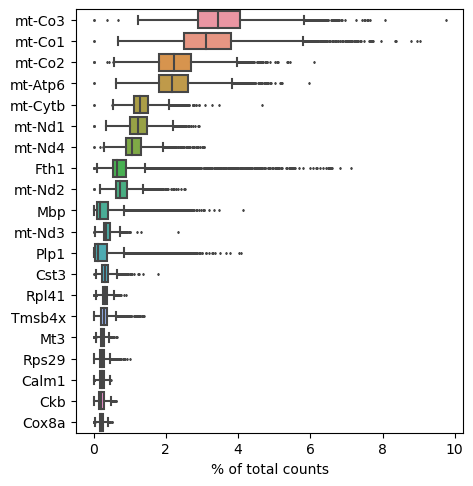

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

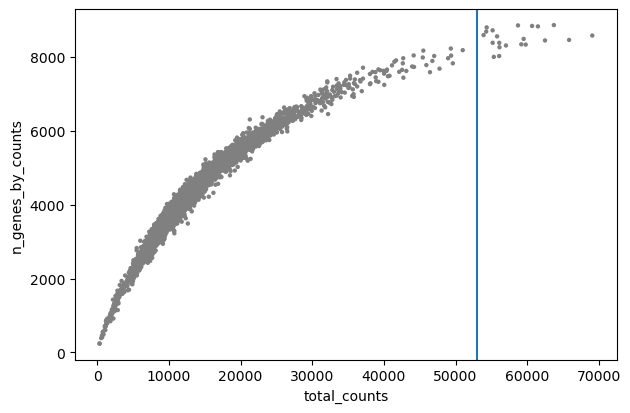

In [8]:
ax = sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=False)
ax.axvline(x=53000)

In [9]:
adata = adata[adata.obs.n_genes_by_counts < 53000, :]

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)

/vol/data/ttreis/envs/cellij/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
sc.pp.log1p(adata)

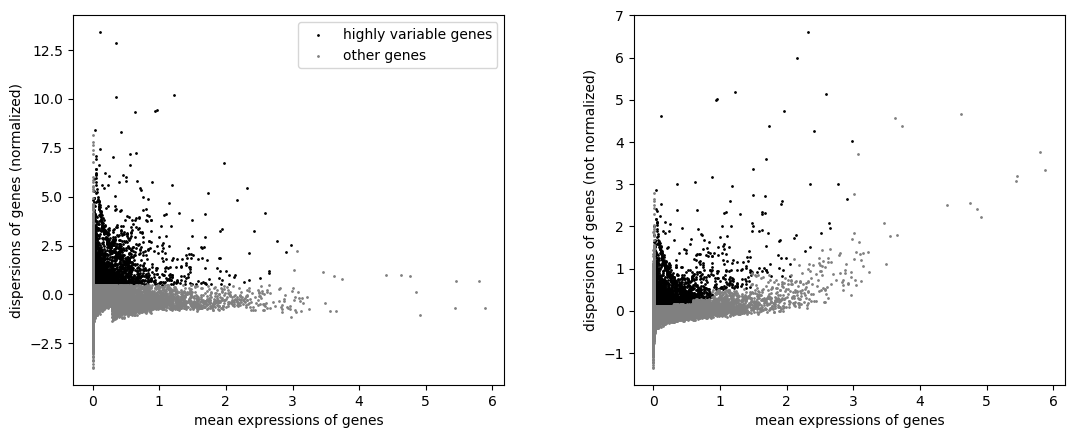

In [12]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [13]:
adata = adata[:, adata.var.highly_variable]

In [14]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [15]:
sc.pp.scale(adata, max_value=10)

In [16]:
adata

AnnData object with n_obs × n_vars = 2983 × 2953
    obs: 'in_tissue', 'array_row', 'array_col', 'annotating', 'library', 'spot_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'spatialdata_attrs', 'log1p', 'hvg'

In [17]:
obs = adata.obs
obs = obs[["array_row", "array_col", "spot_id"]]
# obs.index = [f"spot_{i:04}" for i in obs.spot_id.values.tolist()]
del obs["spot_id"]
obs.columns = ["y", "x"]
obs

,y,x
AAACAAGTATCTCCCA-1,50,102
AAACACCAATAACTGC-1,59,19
AAACAGAGCGACTCCT-1,14,94
AAACAGCTTTCAGAAG-1,43,9
AAACAGGGTCTATATT-1,47,13
...,...,...
TTGTTCAGTGTGCTAC-1,24,64
TTGTTGTGTGTCAAGA-1,31,77
TTGTTTCACATCCAGG-1,58,42
TTGTTTCATTAGTCTA-1,60,30


In [18]:
dense_data = adata.X.astype(float)
data = pd.DataFrame(
    dense_data,
    columns=adata.var.index,
    index=adata.obs.index,
)
data

,Xkr4,Sox17,Rgs20,Npbwr1,St18,Sntg1,Adhfe1,3110035E14Rik,1700034P13Rik,Arfgef1,...,Vti1a,Tcf7l2,Afap1l2,Gfra1,Shtn1,Slc18a2,Cacul1,mt-Atp8,mt-Nd4l,Tmlhe
AAACAAGTATCTCCCA-1,2.579940,-0.195891,-0.612518,-0.122587,-0.388318,1.382361,2.916579,-1.074093,0.951560,-0.950594,...,-0.653222,2.263231,-0.281638,1.046707,-0.540288,-0.108278,-0.637761,1.486951,1.022664,-0.127634
AAACACCAATAACTGC-1,-0.484346,-0.212142,-0.593625,-0.107642,-0.442996,-0.475200,-0.489767,-0.889667,1.433805,-0.877608,...,-0.630077,-0.741339,-0.301516,-0.527490,-0.578824,-0.120460,1.508650,-0.074216,1.506086,-0.146865
AAACAGAGCGACTCCT-1,-0.396278,-0.128844,0.762383,-0.184246,-0.162740,1.730362,-0.274121,1.148992,-0.595345,-0.577470,...,0.699174,-0.222502,2.518628,0.154956,-0.381305,-0.058021,-0.762125,-0.557268,0.529312,-0.048295
AAACAGCTTTCAGAAG-1,-0.492342,-0.219705,3.195881,-0.100686,-0.468442,-0.463065,-0.509347,0.557280,1.785826,-0.843643,...,-0.619306,-0.788446,-0.310767,-0.515313,-0.596757,-0.126129,-0.593587,1.684427,1.469680,-0.155814
AAACAGGGTCTATATT-1,1.360882,-0.195148,1.992724,-0.123270,-0.385819,-0.502466,-0.445772,1.129089,0.935111,-0.953930,...,-0.654280,-0.635487,-0.280730,-0.554852,-0.538526,-0.107722,-0.639138,0.974133,0.214977,-0.126755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.229342,-0.002393,-0.412859,-0.300537,0.262705,0.129464,0.053242,-1.630650,0.233303,-1.159325,...,-0.928801,0.771559,-0.044962,-0.438945,0.731676,0.036765,-0.189913,0.381060,-0.075835,0.101340
TTGTTGTGTGTCAAGA-1,-0.488975,-0.216520,-0.588535,-0.103615,-0.457726,-0.468175,-0.501101,-0.839985,-0.625877,2.097305,...,2.929282,1.400207,-0.306871,-0.520441,1.741452,-0.123742,-0.599495,-2.629933,-0.124535,-0.152045
TTGTTTCACATCCAGG-1,-0.444671,-0.174616,0.583037,-0.142152,1.201296,-0.535409,-0.392618,0.520758,-0.611285,0.682608,...,0.532598,0.085665,-0.255616,1.505772,0.755816,-0.092331,-0.677223,0.299637,1.093197,-0.102459
TTGTTTCATTAGTCTA-1,1.062801,-0.180634,1.584002,-0.136618,-0.336985,1.018181,-0.408196,0.683654,-0.613380,0.816265,...,-0.674952,-0.545081,2.181830,0.733528,-0.504109,-0.096842,-0.666061,-0.518344,1.176356,-0.109579


In [19]:
torch.cuda.is_available()

True

In [20]:
torch.cuda.empty_cache()
# del model

In [21]:
model = cellij.core.models.SimpleGP(
    n_factors=2,
    device="cuda"
)

model.add_data(name="visium", data=data)
model.add_covariate(obs, num_inducing_points=200)
model.fit(
    likelihoods="Normal",
    epochs=2000,
    verbose_epochs=100,
    learning_rate=0.01,
    early_stopping=False
)


Training Model...
- Epoch      0/2000 | Train Loss:           0.00 	
- Epoch    100/2000 | Train Loss:           3.92 	| Decrease: -356488.89%	| Time:  22.65s
- Epoch    200/2000 | Train Loss:           3.31 	| Decrease:  15.50%	| Time:  22.77s
- Epoch    300/2000 | Train Loss:           2.83 	| Decrease:  14.51%	| Time:  22.90s
- Epoch    400/2000 | Train Loss:           2.34 	| Decrease:  17.32%	| Time:  22.99s
- Epoch    500/2000 | Train Loss:           2.03 	| Decrease:  13.38%	| Time:  23.03s
- Epoch    600/2000 | Train Loss:           1.65 	| Decrease:  18.58%	| Time:  23.06s
- Epoch    700/2000 | Train Loss:           1.51 	| Decrease:   8.73%	| Time:  23.07s
- Epoch    800/2000 | Train Loss:           1.25 	| Decrease:  17.15%	| Time:  23.07s
- Epoch    900/2000 | Train Loss:           1.09 	| Decrease:  12.37%	| Time:  23.06s
- Epoch   1000/2000 | Train Loss:           0.94 	| Decrease:  14.19%	| Time:  23.05s
- Epoch   1100/2000 | Train Loss:           0.84 	| Decrease:  10.2

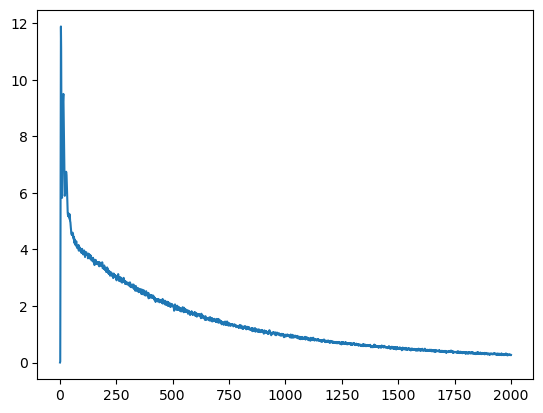

In [22]:
plt.plot(model.train_loss_elbo)

<Axes: >

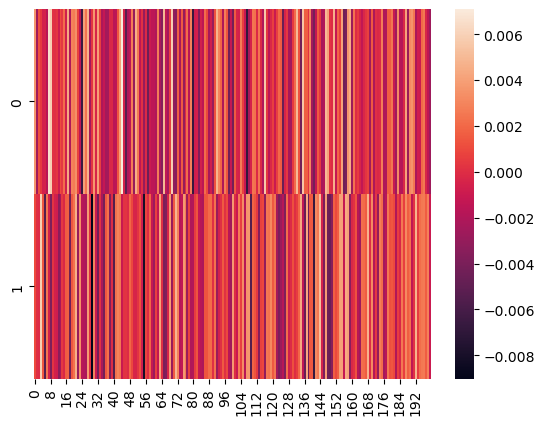

In [23]:
a = pyro.get_param_store()["FactorModel._guide.gp$$$variational_strategy._variational_distribution.variational_mean"]
sns.heatmap(a.cpu().detach().numpy())

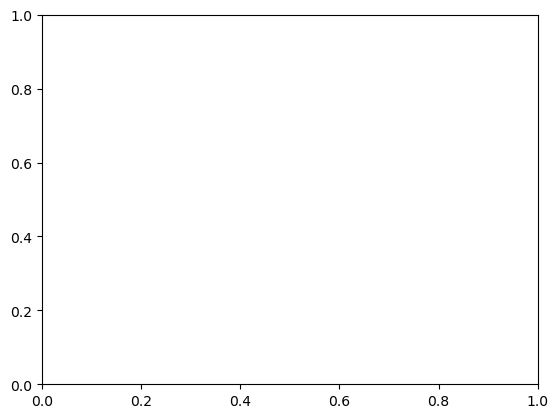

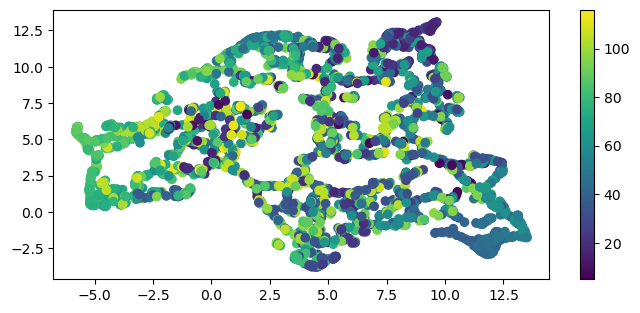

In [24]:
factor_means = []
with torch.no_grad():
    dist = model.gp(model.covariate)
    samples = dist(torch.Size([10000])).cpu()
    mean = samples.mean(dim=0)
    mean = torch.transpose(mean, -1, -2)
    factor_means.append(torch.transpose(mean, -1, -2))

factor_means = torch.stack(factor_means, dim=0)

for i in range(10):
    try:
        plt.scatter(model.covariate.cpu().detach().numpy(), factor_means.squeeze()[i], )
    except:
        pass
    
umap_obj = umap.UMAP()
result = umap_obj.fit_transform(factor_means.squeeze().T)

# pca = PCA(n_components=2)
# result = pca.fit_transform(factor_means.squeeze().T)

result = pd.DataFrame(result)
result["time"] = obs["x"].values
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8, 3.5))
s = axs.scatter(result[0], result[1], c = result["time"])
fig.colorbar(s, ax=axs)

In [25]:
factor = factor_means.squeeze()[3,:]
factor = pd.DataFrame({
    "val": factor.numpy(),
    "x":obs["x"],
    "y":obs["y"]
})
factor

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axs[0].scatter(factor.x, factor.y, c=factor.val, cmap='viridis', edgecolors='black')

# Add colorbar for intensity values
cbar = fig.colorbar(axs[0].collections[0], ax=axs[0])
cbar.set_label('Intensity (val)')

# Set labels for the axes
axs[0].set_xlabel('X Coordinates')
axs[0].set_ylabel('Y Coordinates')
axs[0].invert_yaxis()
sdata.pl.render_images().pl.show(ax=axs[1])

for ax in axs:
    ax.set_aspect('equal', adjustable='box')

IndexError: index 3 is out of bounds for dimension 0 with size 2

In [ ]:
for i in range(factor_means.squeeze().shape[0]):
    sdata.table.obs[f"factor{i}"] = factor_means.squeeze()[i,:]

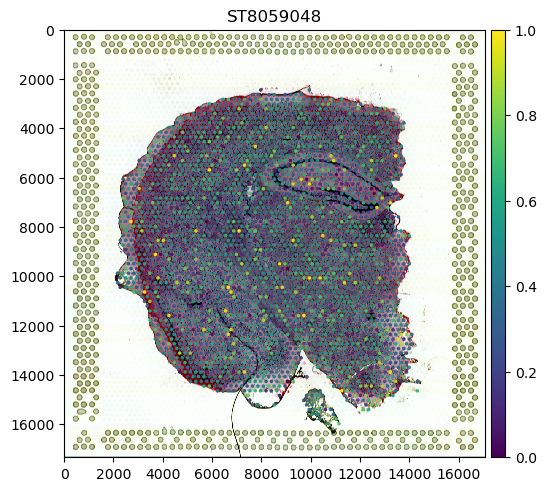

In [ ]:
sdata.pl.render_images().pl.render_shapes(color="factor0").pl.show()

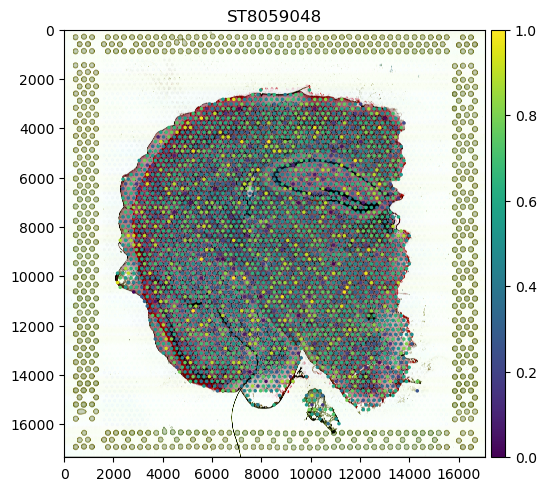

In [ ]:
sdata.pl.render_images().pl.render_shapes(color="factor1").pl.show()

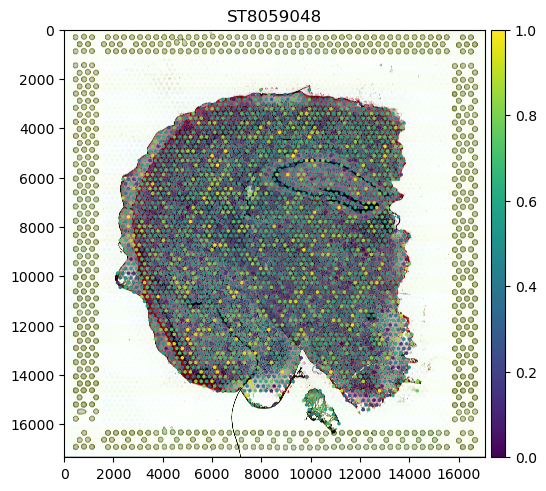

In [ ]:
sdata.pl.render_images().pl.render_shapes(color="factor2").pl.show()

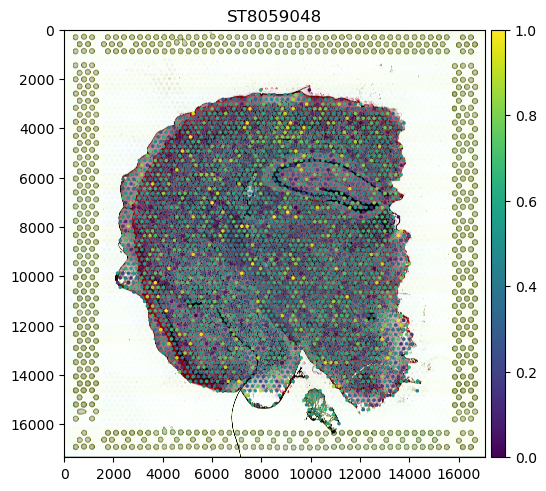

In [ ]:
sdata.pl.render_images().pl.render_shapes(color="factor3").pl.show()

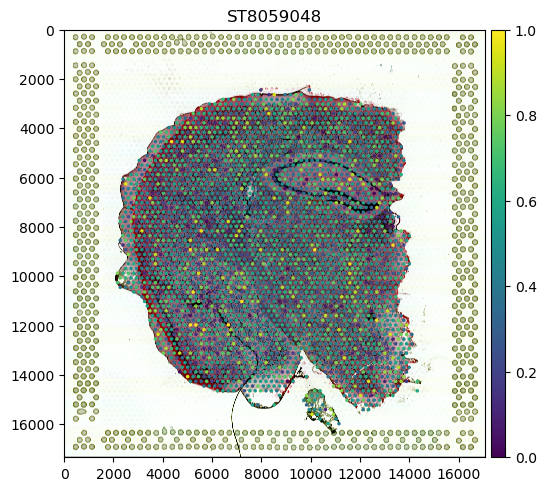

In [ ]:
sdata.pl.render_images().pl.render_shapes(color="factor4").pl.show()